# Malawi Flood Challenge

In [1]:
# import librairies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import seaborn as sns
from sklearn import datasets
import pygeohash as pgh
from sklearn.preprocessing import LabelEncoder
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
from geojson import Point, MultiPoint
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [2]:
#import and explore data
data = pd.read_csv('Train.csv')
sample = pd.read_csv('SampleSubmission.csv')
data.head()

,X,Y,target_2015,elevation,precip 2014-11-16 - 2014-11-23,precip 2014-11-23 - 2014-11-30,precip 2014-11-30 - 2014-12-07,precip 2014-12-07 - 2014-12-14,precip 2014-12-14 - 2014-12-21,precip 2014-12-21 - 2014-12-28,...,precip 2019-03-24 - 2019-03-31,precip 2019-03-31 - 2019-04-07,precip 2019-04-07 - 2019-04-14,precip 2019-04-14 - 2019-04-21,precip 2019-04-21 - 2019-04-28,precip 2019-04-28 - 2019-05-05,precip 2019-05-05 - 2019-05-12,precip 2019-05-12 - 2019-05-19,LC_Type1_mode,Square_ID
0,34.26,-15.91,0.0,887.764222,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3896-14ce-11ea-bce5-f49634744a41
1,34.26,-15.90,0.0,743.403912,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3897-14ce-11ea-bce5-f49634744a41
2,34.26,-15.89,0.0,565.728343,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,9,4e3c3898-14ce-11ea-bce5-f49634744a41
3,34.26,-15.88,0.0,443.392774,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c3899-14ce-11ea-bce5-f49634744a41
4,34.26,-15.87,0.0,437.443428,0.0,0.0,0.0,14.844025,14.552823,12.237766,...,0.896323,1.68,0.0,0.0,0.0,0.0,0.0,0.0,10,4e3c389a-14ce-11ea-bce5-f49634744a41


In [3]:
#look for missing data 
cols_with_missing = [col for col in data.columns
                     if data[col].isnull().any()]

In [4]:
#Divide the data into train, validation and test data
train_features = ['X', 'Y', 'elevation', 'precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15','LC_Type1_mode']
test_features = ['X', 'Y','elevation','precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
       'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
       'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
       'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
       'precip 2019-05-12 - 2019-05-19', 'LC_Type1_mode']
X = data[train_features].copy()
X_test = data[test_features].copy()
y = data['target_2015'].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                      random_state=0)


# Testing different models

In [5]:
#test random forest and change hyperparameters
Random_Forest_model = RandomForestRegressor(n_estimators=100, random_state=0)
Random_Forest_model.fit(X_train, y_train)
ypred = abs(Random_Forest_model.predict(X_valid))
print(sum(abs(ypred - y_valid)))

50.6281205308808


In [6]:
#test xgboost and change hyperparmeters
XGB_model = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=4)
XGB_model.fit(X_train, y_train)
ypred = abs(XGB_model.predict(X_valid))
print(sum(abs(ypred - y_valid)))


[11:49:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
103.79791513738863


In [7]:
models = [Random_Forest_model, XGB_model]

for model in models:
    
    score = -1 * cross_val_score(model, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    print("Average MAE score for",model, "is", score.mean())
    

Average MAE score for RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False) is 0.09314607509830566
[11:50:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:50:10] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederro

In [8]:
#test lgb and change hyperparameters
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid)
param = {'num_leaves': 200, 'objective': 'binary'}
param['metric'] = 'l1'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)
ypred = abs(bst.predict(X_valid))
print(sum(abs(ypred - y_valid)))

137.7343432648075


In [9]:
#test catboost and change hyperparameters
cat_model = CatBoostRegressor(iterations=30, learning_rate=0.6, depth=10)
cat_model.fit(X_train, y_train)
preds = cat_model.predict(X_valid)
print(sum(abs(preds - y_valid)))

0:	learn: 0.1667690	total: 430ms	remaining: 12.5s
1:	learn: 0.1424502	total: 785ms	remaining: 11s
2:	learn: 0.1341229	total: 1.14s	remaining: 10.2s
3:	learn: 0.1299886	total: 1.47s	remaining: 9.53s
4:	learn: 0.1237261	total: 1.78s	remaining: 8.93s
5:	learn: 0.1232402	total: 1.82s	remaining: 7.3s
6:	learn: 0.1227176	total: 2.14s	remaining: 7.02s
7:	learn: 0.1182501	total: 2.46s	remaining: 6.76s
8:	learn: 0.1164206	total: 2.85s	remaining: 6.66s
9:	learn: 0.1157875	total: 3.21s	remaining: 6.42s
10:	learn: 0.1148356	total: 3.6s	remaining: 6.22s
11:	learn: 0.1128288	total: 3.95s	remaining: 5.92s
12:	learn: 0.1125903	total: 4.28s	remaining: 5.6s
13:	learn: 0.1112057	total: 4.61s	remaining: 5.27s
14:	learn: 0.1111543	total: 4.74s	remaining: 4.74s
15:	learn: 0.1111533	total: 4.79s	remaining: 4.19s
16:	learn: 0.1111529	total: 4.88s	remaining: 3.73s
17:	learn: 0.1095274	total: 5.23s	remaining: 3.49s
18:	learn: 0.1093676	total: 5.58s	remaining: 3.23s
19:	learn: 0.1081962	total: 5.91s	remaining: 2

# Feature engineering


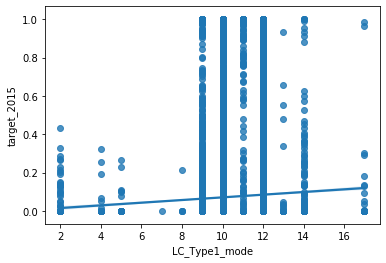

In [5]:
#check the different correlations between features
sns.regplot(x= X_train.LC_Type1_mode, y = y_train)

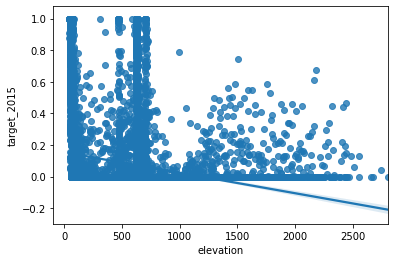

In [6]:
sns.regplot(x= X_train.elevation, y = y_train)

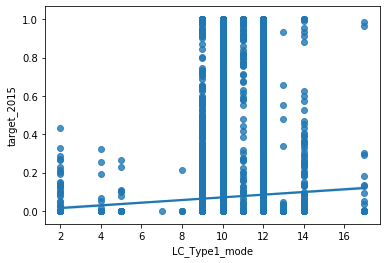

In [7]:
sns.regplot(x= X_train.LC_Type1_mode , y = y_train)

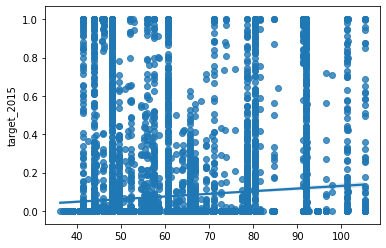

In [8]:
feat = ['precip 2014-11-16 - 2014-11-23',
       'precip 2014-11-23 - 2014-11-30', 'precip 2014-11-30 - 2014-12-07',
       'precip 2014-12-07 - 2014-12-14', 'precip 2014-12-14 - 2014-12-21',
       'precip 2014-12-21 - 2014-12-28', 'precip 2014-12-28 - 2015-01-04',
       'precip 2015-01-04 - 2015-01-11', 'precip 2015-01-11 - 2015-01-18',
       'precip 2015-01-18 - 2015-01-25', 'precip 2015-01-25 - 2015-02-01',
       'precip 2015-02-01 - 2015-02-08', 'precip 2015-02-08 - 2015-02-15',
       'precip 2015-02-15 - 2015-02-22', 'precip 2015-02-22 - 2015-03-01',
       'precip 2015-03-01 - 2015-03-08', 'precip 2015-03-08 - 2015-03-15']
test_feat = ['precip 2019-01-20 - 2019-01-27', 'precip 2019-01-27 - 2019-02-03',
       'precip 2019-02-03 - 2019-02-10', 'precip 2019-02-10 - 2019-02-17',
       'precip 2019-02-17 - 2019-02-24', 'precip 2019-02-24 - 2019-03-03',
       'precip 2019-03-03 - 2019-03-10', 'precip 2019-03-10 - 2019-03-17',
       'precip 2019-03-17 - 2019-03-24', 'precip 2019-03-24 - 2019-03-31',
       'precip 2019-03-31 - 2019-04-07', 'precip 2019-04-07 - 2019-04-14',
       'precip 2019-04-14 - 2019-04-21', 'precip 2019-04-21 - 2019-04-28',
       'precip 2019-04-28 - 2019-05-05', 'precip 2019-05-05 - 2019-05-12',
       'precip 2019-05-12 - 2019-05-19']
#calculating the maximum of precipitation for the train data
precip_max =X_train[feat].max(axis =1)
sns.regplot(x= precip_max , y = y_train)

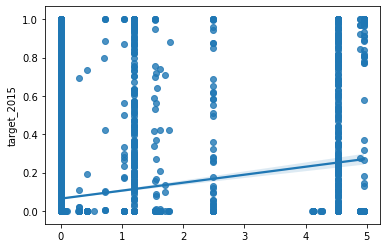

In [9]:
precip_min =X_train[feat].min(axis =1)
sns.regplot(x=precip_min  , y = y_train)

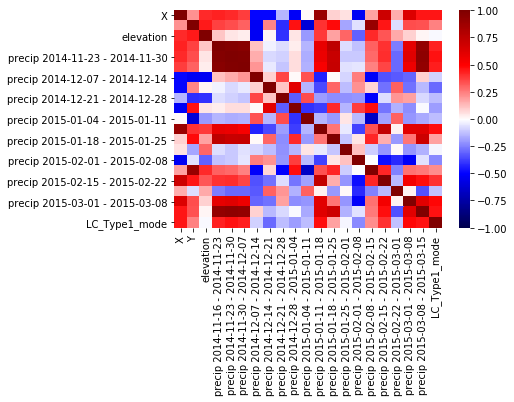

In [10]:
sns.heatmap(X_train.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

[26522.7689967365, 41198.88160486021, 19134.741766817104, 136183.85696054372, 146423.23278920318, 157626.06441133458, 377483.6478926689, 462912.1164237642, 969175.7180148631, 20601.818552636203, 570599.2198789973, 466232.9503488563, 205625.9095286183, 62613.3432921204, 281112.25228885177, 150020.87908741258, 5444.3347560449]


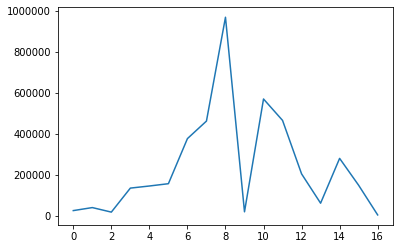

In [11]:
#check the precipitations total according to their week
tab = []
for i in range(len(feat)):
    tab.append(np.sum(X[feat[i]]))
print(tab)
plt.plot(tab)

[219475.69763500363, 73067.70599106721, 381179.6738812691, 160539.9620923185, 486998.2682775755, 30699.1938149612, 994957.4586064437, 202887.7875499328, 586804.6740108465, 35010.5638486014, 56863.6081942168, 58608.5284523836, 150296.3230601703, 27345.2353206171, 8663.4820412421, 15940.751205129502, 26110.849721709303]
precip 2019-02-03 - 2019-02-10


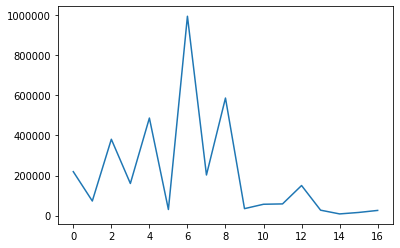

In [12]:
tab = []
for i in range(len(test_feat)):
    tab.append(np.sum(data[test_feat[i]]))
print(tab)
plt.plot(tab)
print(test_feat[len(test_feat)-15])

In [13]:
#adding some features: mean, min, max, std, 25%, 50%, 75% and std 
data['mean'] =data[feat].mean(axis =1)
data['max'] = data[feat].max(axis =1)
data['min'] = data[feat].min(axis =1)
data['std'] = data[feat].std(axis = 1)
data['25percentile'] = np.percentile(data[feat],25, axis =1)
data['50percentile'] = np.percentile(data[feat],50, axis =1)
data['75percentile'] = np.percentile(data[feat],75, axis =1)
data['test_mean'] = data[test_feat].mean(axis =1)
data['test_max'] = data[test_feat].mean(axis = 1)
data['test_min'] = data[test_feat].min(axis = 1)
data['test_std'] = data[test_feat].std(axis = 1)
data['test_25percentile'] = np.percentile(data[test_feat],25, axis =1)
data['test_50percentile'] = np.percentile(data[test_feat],50, axis =1)
data['test_75percentile'] = np.percentile(data[test_feat],75, axis =1)


#Add new precipitation columns that add up precipitations over each 2 weeks
for i in range(0,16,2):
    data["precip" + str(i)] = data[[feat[i],feat[i+1]]].sum(axis =1)
for i in range(0,16,2):
    data["test_precip" + str(i)] = data[[test_feat[i],test_feat[i+1]]].sum(axis =1)
data1 = data.copy()
#keep the precipitations calculated over 2 weeks and delete the precipitations for each week data
train_features = [ 'X', 'Y','elevation', 'precip0','precip2',
                  'precip4', 'precip6', 'precip8','precip10', 'precip12', 'precip14',
                 'LC_Type1_mode', 'mean', 'max']
test_features = [ 'X', 'Y','elevation','test_precip0','test_precip2', 'test_precip4', 'test_precip6',
                  'test_precip8','test_precip10', 'test_precip12', 'test_precip14',
                 'LC_Type1_mode','test_mean', 'test_max']
X_test = data1[test_features].copy()
X_test.columns = [ 'X', 'Y','elevation', 'precip0','precip2',
                  'precip4', 'precip6', 'precip8','precip10', 'precip12', 'precip14',
                 'LC_Type1_mode', 'mean', 'max']
X = data1[train_features].copy()
y = data1['target_2015'].copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                      random_state=0)


# Testing Models After Feature Engineering

In [64]:
#try with catboost
cat_model = CatBoostRegressor(iterations=30, learning_rate=0.6, depth=10)
cat_model.fit(X_train, y_train)
preds = cat_model.predict(X_valid)
print(sum(abs(preds - y_valid)))
ypred = abs(cat_model.predict(X_test))
cat_result = pd.DataFrame({'Square_ID': data.Square_ID, 'target_2019':ypred })
cat_result.to_csv('output.csv', index=False) 
cat_result.head()

0:	learn: 0.1690348	total: 307ms	remaining: 8.9s
1:	learn: 0.1431938	total: 553ms	remaining: 7.74s
2:	learn: 0.1334216	total: 844ms	remaining: 7.6s
3:	learn: 0.1285708	total: 1.12s	remaining: 7.27s
4:	learn: 0.1242891	total: 1.35s	remaining: 6.75s
5:	learn: 0.1223209	total: 1.6s	remaining: 6.39s
6:	learn: 0.1215799	total: 1.85s	remaining: 6.08s
7:	learn: 0.1205584	total: 2.1s	remaining: 5.77s
8:	learn: 0.1185743	total: 2.35s	remaining: 5.49s
9:	learn: 0.1175636	total: 2.6s	remaining: 5.2s
10:	learn: 0.1175616	total: 2.69s	remaining: 4.65s
11:	learn: 0.1169846	total: 2.96s	remaining: 4.44s
12:	learn: 0.1166966	total: 3.2s	remaining: 4.18s
13:	learn: 0.1154888	total: 3.45s	remaining: 3.94s
14:	learn: 0.1154886	total: 3.48s	remaining: 3.48s
15:	learn: 0.1150212	total: 3.72s	remaining: 3.26s
16:	learn: 0.1143748	total: 3.99s	remaining: 3.05s
17:	learn: 0.1135318	total: 4.25s	remaining: 2.84s
18:	learn: 0.1135318	total: 4.27s	remaining: 2.47s
19:	learn: 0.1135318	total: 4.29s	remaining: 2.1

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.009667
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.009667
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.020191
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.017124
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.017124


In [66]:
#Try with random forest
Random_Forest_model = RandomForestRegressor(n_estimators=100, random_state=0)
Random_Forest_model.fit(X_train, y_train)
ypred = abs(Random_Forest_model.predict(X_valid))
print(sum(abs(ypred - y_valid)))
pred = abs(Random_Forest_model.predict(X_test))
rf_result = pd.DataFrame({'Square_ID': data.Square_ID, 'target_2019':pred })
rf_result.to_csv('output.csv', index=False) 
rf_result.head()

49.27465292161295


,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.004668
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.004668
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.005481
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.008532
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.009926


In [67]:
# try lightgbm
X_trainbis= X_train.copy()
X_validbis= X_valid.copy()
X_testbis = X_test.copy()
dtrain = lgb.Dataset(X_trainbis, label=y_train)
dvalid = lgb.Dataset(X_validbis, label=y_valid)
param = {'num_leaves': 200, 'objective': 'binary'}
param['metric'] = 'l1'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=10, verbose_eval=False)

In [68]:
ypred = abs(bst.predict(X_validbis))
print(sum(abs(ypred - y_valid)))


137.98673469056143


In [69]:
ypred = abs(bst.predict(X_test))
lgb_result = pd.DataFrame({'Square_ID': data.Square_ID, 'target_2019':ypred })
lgb_result.to_csv('output.csv', index=False) 
lgb_result.head()

,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.000022
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.000026
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.000047
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.000052
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.000130


In [70]:
#XGB gives better results 
#XGB hyperparameter tuning
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor( learning_rate=0.1, n_estimators=100, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='neg_mean_absolute_error', n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_train, y_train)
gsearch2.best_params_, gsearch2.best_score_


C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[13:31:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 6, 'min_child_weight': 6}, -0.04299300183850093)

In [34]:
#tuning gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100, max_depth=6,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_train, y_train)
gsearch3.best_params_, gsearch3.best_score_

[11:39:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'gamma': 0.0}, -0.0433169584846527)

In [35]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100, max_depth=6,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='neg_mean_absolute_error', n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

[11:39:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.9, 'subsample': 0.9}, -0.042574349458928934)

In [36]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100, max_depth=6,
 min_child_weight=6, gamma=0, subsample=0.9, colsample_bytree=0.9, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_mean_absolute_error', n_jobs=4,iid=False, cv=5)
gsearch5.fit(X_train, y_train)
gsearch5.best_params_, gsearch5.best_score_

[11:39:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'colsample_bytree': 0.8, 'subsample': 0.85}, -0.043251222786815605)

In [37]:
param_test6 = {
 'reg_alpha':[1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate =0.1, n_estimators=100, max_depth=6,
 min_child_weight=6, gamma=0.1, subsample=0.8, colsample_bytree=0.8,
 nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_absolute_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train, y_train)
gsearch6.best_params_, gsearch6.best_score_

[11:40:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1e-06}, -0.04421319325074055)

In [71]:

XGB_model = XGBRegressor(learning_rate =0.04,
 n_estimators=103,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
reg_alpha = 1e-6,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
XGB_model.fit(X_train, y_train)
ypred = abs(XGB_model.predict(X_valid))
print(sum(abs(ypred - y_valid)))
pred = abs(XGB_model.predict(X_test))
XGB_result = pd.DataFrame({'Square_ID': data.Square_ID, 'target_2019':pred })
XGB_result.to_csv('output.csv', index=False) 
XGB_result.head()

[13:34:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
81.8359855855672


,Square_ID,target_2019
0,4e3c3896-14ce-11ea-bce5-f49634744a41,0.011298
1,4e3c3897-14ce-11ea-bce5-f49634744a41,0.011298
2,4e3c3898-14ce-11ea-bce5-f49634744a41,0.031355
3,4e3c3899-14ce-11ea-bce5-f49634744a41,0.033307
4,4e3c389a-14ce-11ea-bce5-f49634744a41,0.033307
